In [1]:
import pandas as pd
import numpy as np
from statsmodels.stats.multitest import multipletests

In [ ]:
# df has 4059 features and 158 samples
df= pd.read_csv("../data/trans_omic_untargeted/prs_feat_table_pos.csv") # 4059 Features
# df= pd.read_csv("../data/trans_omic_untargeted/prs_feat_table_pos_rsd_1.csv") # 13175 Features
df_feat_to_samples = df[[col for col in df.columns if col.startswith('2') or col=='namecustom']]
print("Number of Features:", len(df))

# df meta has 643 samples (decreased to 158)
df_meta = pd.read_csv("../data/trans_omic_untargeted/meta_data.csv")
df_meta = df_meta[['sample_id', 'is_bad', 'age']]
df_meta = df_meta[df_meta['sample_id'].isin(df.columns)] #158
# merge_df
df_transposed = df_feat_to_samples.set_index('namecustom').T
df_comb = df_meta.merge(
    right=df_transposed, 
    left_on='sample_id', 
    right_index=True, 
    how='left')
print(len(df_comb))
print(df_comb.head())      

# group data
bad = df_comb[df_comb["is_bad"]==1]
good = df_comb[df_comb["is_bad"]==0]

Number of Features: 4059
158
                sample_id  is_bad  age  M70.065243T44.3972  \
1  20P02820001_BEHC18_POS       0   38        9.586599e+06   
3  20P02820002_BEHC18_POS       0   57        7.135026e+06   
5  20P02820006_BEHC18_POS       1   49        6.042677e+06   
7  20P02820016_BEHC18_POS       1   24        1.952811e+07   
9  20P02820017_BEHC18_POS       1   37        1.761037e+07   

   M70.162528T573.481  M70.568609T582.7159_1  M70.718387T490.9966_1  \
1       152733.793741           1.630222e+06          769056.181092   
3       125497.917435           1.679354e+06          807231.527254   
5        99834.854269           1.773759e+06          679367.482137   
7       139953.362975           1.458265e+06          938669.770498   
9        86720.271128           1.464937e+06          892747.678781   

   M70.819398T582.6421_2  M70.941944T765.5022  M70.958049T4.4722  ...  \
1          227864.664375         2.677927e+06       1.218231e+06  ...   
3          258794.366745 

In [3]:
def run_ttest(features, test_data):
    from scipy.stats import ttest_ind
    
    bad = test_data[test_data["is_bad"]==1]
    good = test_data[test_data["is_bad"]==0]

    log_2_FC = []
    p_values = []
    stats = []
    for feature in features:
        t_stat, p_val = ttest_ind(bad[feature], good[feature], equal_var=True)
        log_FC = np.log2(good[feature].mean()) - np.log2(bad[feature].mean())
        
        stats.append(t_stat)
        p_values.append(p_val)
        log_2_FC.append(log_FC)
    
    return p_values, stats, log_2_FC

In [ ]:
def run_ancova(features, test_data):
    from pingouin import ancova
    import statsmodels.formula.api as smf
    
    log_2_FC = []
    p_values = []
    stats = []
        
    for feature in features:
        ancova_res = ancova(data=test_data, dv=feature, covar='age', between='is_bad')
        p_val = ancova_res.loc[ancova_res['Source'] == 'is_bad', 'p-unc'].values[0]
        f_stat = ancova_res.loc[ancova_res['Source'] == 'is_bad', 'F'].values[0]

        # Adjusted mean for FC calculation
        formula = f"Q('{feature}') ~ C(is_bad) + age"
        model = smf.ols(formula, data=test_data[["is_bad", "age", feature]]).fit()
        adjusted_means = model.predict(pd.DataFrame({
            'is_bad': [0, 1],
            'age': [test_data['age'].mean()] * 2
        }))
        log_FC = np.log2(adjusted_means[0]) - np.log2(adjusted_means[1])
        # log_2_FC.append(np.log2(good[feature].mean()) - np.log2(bad[feature].mean()))

        stats.append(f_stat)
        p_values.append(p_val)
        log_2_FC.append(log_FC)
    
    return p_values, stats, log_2_FC

In [4]:
# t-test for each feature

features = [col for col in df_comb.columns if col.startswith('M')]
p_values, stats, log_2_FC = run_ttest(features, df_comb)
# p_values, stats, log_2_FC = run_ancova(features, df_comb)

# Correction - Bonferroni / Benjamini-Hochberg
adjusted_p_bon = multipletests(p_values, method='bonferroni')[1]
adjusted_p_bh_fdr = multipletests(p_values, method='fdr_bh')[1]

# all_results
all_results = pd.DataFrame({
    "feature": features, 
    "t-score": stats, 
    "p-values": p_values,
    "adjusted p-values (bon)": adjusted_p_bon,
    "adjusted p-values (bh_fdr)": adjusted_p_bh_fdr,
    "mz": df["mz"],
    "rtime": df["rt"],
    })
significant_res_bh = all_results[all_results["adjusted p-values (bh_fdr)"] < 0.05]
print(len(significant_res_bh)) # 753 abundant features through t-test (553 through ancova)

# significant_res_bh.to_csv("results/t_test_significant_results_bh.csv")
# significant_res_bh.to_csv("results/ancova_significant_results_bh.csv")

753


In [ ]:
# mummichog_input = pd.DataFrame({
#     "m/z": df["mz"],
#     "retention_time": df["rt"],
#     "p-value": adjusted_p_bh_fdr,
#     "t-score": stats,
#     "custom_id": features
# })

# mummichog_input.to_csv("mummichog_input_ttest_rsd_1.csv", index=False)
# mummichog_input.to_csv("mummichog_input_ancova.csv", index=False)

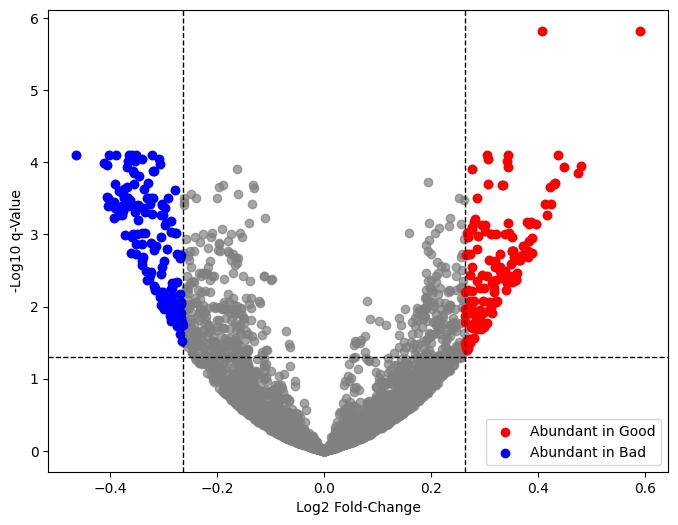

In [5]:
# Visualise volcano plot
import matplotlib.pyplot as plt


plot_data = pd.DataFrame({
    "log2FC": log_2_FC,
    "adjusted p-values": all_results["adjusted p-values (bh_fdr)"]
    # "adjusted p-values": all_results["adjusted p-values (bon)"]
})
plot_data["-log10(p-value)"] = -np.log10(plot_data["adjusted p-values"])
fc_thresh = np.log2(1.2) # FC of 1.2
p_thresh = 0.05

plt.figure(figsize=(8, 6))
plt.scatter(plot_data["log2FC"], plot_data["-log10(p-value)"], color="gray", alpha=0.7)

significant_up = plot_data[(plot_data["log2FC"] > fc_thresh) & (plot_data["adjusted p-values"] < p_thresh)]
significant_down = plot_data[(plot_data["log2FC"] < -fc_thresh) & (plot_data["adjusted p-values"] < p_thresh)]
plt.scatter(significant_up["log2FC"], significant_up["-log10(p-value)"], color="red", label="Abundant in Good")
plt.scatter(significant_down["log2FC"], significant_down["-log10(p-value)"], color="blue", label="Abundant in Bad")

plt.axhline(-np.log10(p_thresh), color="black", linestyle="--", linewidth=1)
plt.axvline(fc_thresh, color="black", linestyle="--", linewidth=1)
plt.axvline(-fc_thresh, color="black", linestyle="--", linewidth=1)

plt.xlabel("Log2 Fold-Change")
plt.ylabel("-Log10 q-Value")
plt.legend()
plt.show()

